In [1]:
from gates_no_batch import *
from states import *
from measurements_no_batch import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import cma

In [2]:
n_photons = 10
num_params = 4
num_iteration = 1000
initial_state = np.zeros(n_photons)
initial_state[0] = 1.
gate2 = S_gate(0.3, 0., n_photons) 
gate3 = D_gate(0.2, 0., n_photons)

initial_state = np.einsum('jk,k->j', gate2, initial_state)
initial_state = np.einsum('jk,k->j', gate3, initial_state)

Initial_state


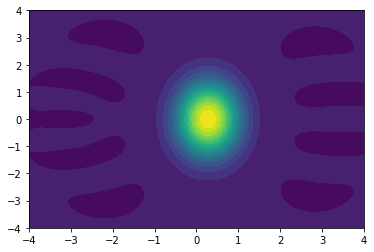

In [3]:
print("Initial_state")
init_state = initial_state.reshape(initial_state.shape[0],1)
rho = np.kron(init_state,init_state.conj().T)
xvec = np.linspace(-4,4,200)
W = wigner_iterative(rho, xvec, xvec)
cont0 = plt.contourf(xvec, xvec, W, 20)
plt.show()

In [4]:
def circuit(initial_state, params, num_params, n_photons):
    
    gate2 = D_gate(params[0], params[1], n_photons) # displacement
    gate3 = S_gate(params[2], params[3], n_photons) # squeezing
    
    state = np.einsum('jk,k->j', gate2, initial_state)
    state = np.einsum('jk,k->j', gate3, state)
    
    data_X = meas_X(state, n_photons)
    data_P = meas_P(state, n_photons)
    return data_X, data_P

def mean_moment(quadrature):
    return np.median(quadrature)

def calc_loss(X, P):
    X_mean = mean_moment(X)
    P_mean = mean_moment(P)
    return X_mean**2 + P_mean**2


In [5]:
def func_to_opt(params):
    X, P = circuit(initial_state, params, num_params, n_photons)
    return calc_loss(X, P)

In [6]:
es = cma.CMAEvolutionStrategy(4*[0.5], 0.2)

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=152017, Wed Jan 15 16:54:17 2020)


In [ ]:
es.optimize(func_to_opt)

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.423357678250002e-01 1.0e+00 1.95e-01  2e-01  2e-01 0:06.7
    2     16 3.730523862500012e-02 1.2e+00 2.41e-01  2e-01  3e-01 0:13.0
    3     24 2.299913299999983e-03 1.6e+00 3.42e-01  3e-01  4e-01 0:19.7
    4     32 3.344977160000033e-02 2.0e+00 3.10e-01  3e-01  4e-01 0:26.5
    5     40 5.302055200000076e-03 2.2e+00 2.76e-01  2e-01  3e-01 0:33.3
    6     48 2.271047424999967e-03 2.2e+00 2.63e-01  2e-01  3e-01 0:41.1
    7     56 4.426250000000251e-04 2.2e+00 2.69e-01  2e-01  3e-01 0:48.0
    8     64 1.550509599999959e-03 2.1e+00 2.57e-01  2e-01  3e-01 0:55.5
   10     80 7.534824999999663e-04 2.5e+00 2.10e-01  1e-01  3e-01 1:09.9


In [ ]:
es.result_pretty()

In [ ]:
params = []

In [ ]:
def test(params, init_state):
    gate2 = D_gate(params[0], params[1], n_photons) # displacement
    gate3 = S_gate(params[2], params[3], n_photons) # squeezing
    
    state = np.einsum('jk,k->j', gate2, init_state)
    state = np.einsum('jk,k->j', gate3, state)
    
    return state.reshape(state.shape[0],1)

In [12]:
new_state = test(params, initial_state)
rho = np.kron(new_state,new_state.conj().T)

Final_state


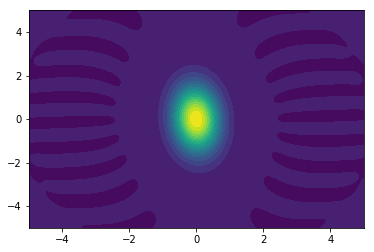

In [13]:
print("Final_state")
xvec = np.linspace(-5,5,200)
W = wigner_iterative(rho, xvec, xvec)
cont0 = plt.contourf(xvec, xvec, W, 20)
plt.show()

In [49]:
state = np.array([1.,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
state /= np.linalg.norm(state)
data_X = meas_X(state, n_photons)
data_P = meas_P(state, n_photons)

In [50]:
np.mean(data_X)**2+np.mean(data_P)**2

0.00018404094097785247